# GENERATIVE ADVERSARIAL NETWORK 

MNIST dataset is used to generate a GAN model to create images of handwritten digits (0-9).

# Loading The Dataset

In [3]:
import torch
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

In [6]:
# Downloading MNIST dataset

mnist = MNIST(root='/home/praveen/Desktop/Projects/GAN', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

Extracting /home/praveen/Desktop/Projects/GAN/MNIST/raw/train-images-idx3-ubyte.gz to /home/praveen/Desktop/Projects/GAN/MNIST/raw


Extracting /home/praveen/Desktop/Projects/GAN/MNIST/raw/train-labels-idx1-ubyte.gz to /home/praveen/Desktop/Projects/GAN/MNIST/raw






Extracting /home/praveen/Desktop/Projects/GAN/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/praveen/Desktop/Projects/GAN/MNIST/raw


Extracting /home/praveen/Desktop/Projects/GAN/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/praveen/Desktop/Projects/GAN/MNIST/raw
Processing...
Done!


In [12]:
# Checking how a data from the dataset looks like.

img, label = mnist[0]
print(img[0][0])
print("Label : ", label)

tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])
Label :  5


In [13]:
# Function to view the pixel values as images

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 5


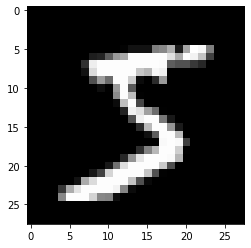

In [18]:
# Lets visualise the image

import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [19]:
# Creating a DataLoader to load the image dataset as batches

from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle = True)

In [20]:
# GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## DISCRIMINATOR NETWORK

In [21]:
# The images are 28*28 images so 756 is the size of each image

image_size = 784

In [25]:
## Simple disriminator architecture

import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid())


In [26]:
# Moving model to GPU

D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## GENERATOR NETWORK

In [31]:
latent_size = 64

G = nn.Sequential(
    nn.Linear(latent_size, 256),
    nn.ReLU(0.2),
    nn.Linear(256, 256),
    nn.ReLU(0.2),
    nn.Linear(256, image_size),
    nn.Tanh())

In [32]:
# Passing a random generated input into the Generator and visualizing the output images

y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

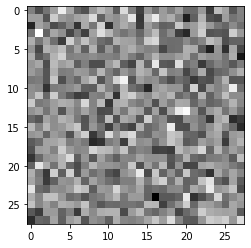

In [33]:
# Image generated by the Generator network
plt.imshow(gen_imgs[0], cmap='gray');

In [34]:
# Moving Generator network to GPU

G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

## TRAINING THE DISCRIMINATOR NETWORK

In [35]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [36]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    
def train_discriminator(images):
    # Creating real and fake labels
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score    
    
    
# Here the gradients of Generator are untouched.

    

## TRAINING THE GENERATOR NETWORK

In [37]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## TRAINING THE WHOLE MODEL

In [39]:
import os

sample_dir = '/home/praveen/Desktop/Projects/GAN/sample/'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

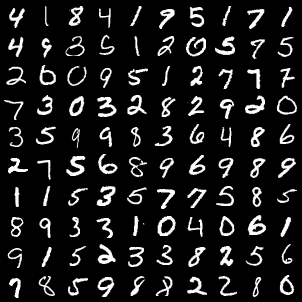

In [40]:
# Saving a sample of a batch of real images 

from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


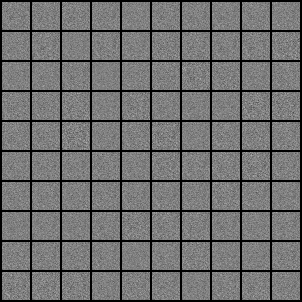

In [41]:
# A sample of a batch of generated images by the Generator 

sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [43]:
# Finally the training



num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0374, g_loss: 4.3774, D(x): 0.99, D(G(z)): 0.03
Epoch [0/300], Step [400/600], d_loss: 0.1016, g_loss: 5.4562, D(x): 0.98, D(G(z)): 0.07
Epoch [0/300], Step [600/600], d_loss: 0.0420, g_loss: 5.5884, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0830, g_loss: 4.3391, D(x): 0.97, D(G(z)): 0.05
Epoch [1/300], Step [400/600], d_loss: 0.1286, g_loss: 5.2033, D(x): 0.97, D(G(z)): 0.03
Epoch [1/300], Step [600/600], d_loss: 0.1683, g_loss: 4.5385, D(x): 0.94, D(G(z)): 0.08
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.5212, g_loss: 3.3209, D(x): 0.85, D(G(z)): 0.18
Epoch [2/300], Step [400/600], d_loss: 0.2287, g_loss: 4.0926, D(x): 0.91, D(G(z)): 0.09
Epoch [2/300], Step [600/600], d_loss: 0.2391, g_loss: 3.3386, D(x): 0.90, D(G(z)): 0.07
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 1.2924, g_loss: 2.6665, D(x): 0.73, D(G(z)): 0.39
Epoch [3/300], Step [400/6

In [44]:
# Save the model checkpoints 
torch.save(G.state_dict(), '/home/praveen/Desktop/Projects/GAN/G.ckpt')
torch.save(D.state_dict(), '/home/praveen/Desktop/Projects/GAN/D.ckpt')

## SAMPLE GENERATED IMAGES

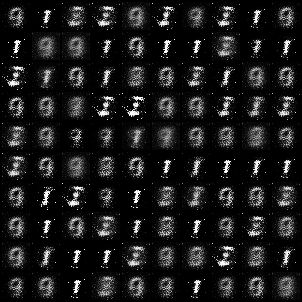

In [45]:
Image('/home/praveen/Desktop/Projects/GAN/sample/fake_images-0010.png')

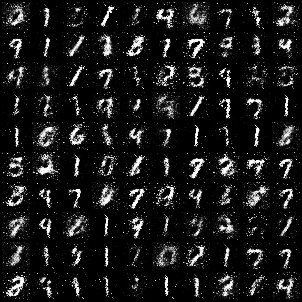

In [46]:
Image('/home/praveen/Desktop/Projects/GAN/sample/fake_images-0044.png')

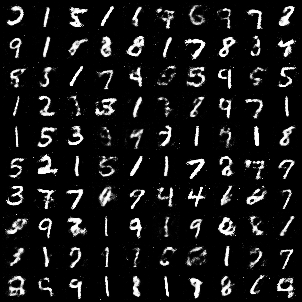

In [48]:
Image('/home/praveen/Desktop/Projects/GAN/sample/fake_images-0150.png')

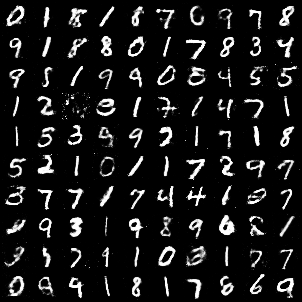

In [49]:
Image('/home/praveen/Desktop/Projects/GAN/sample/fake_images-0300.png')

In [50]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/home/praveen/Desktop/Projects/GAN/gans_training.avi

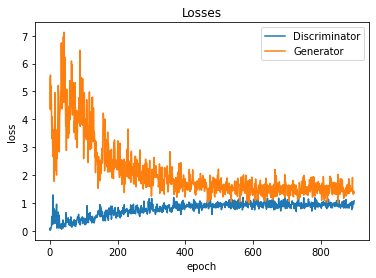

In [51]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

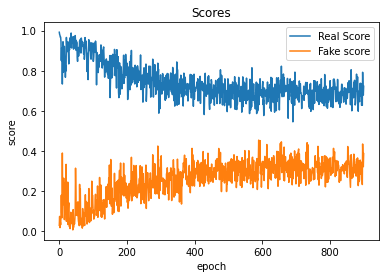

In [52]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [53]:
# Import the library
import jovian

<IPython.core.display.Javascript object>

In [55]:
jovian.commit(outputs=['/home/praveen/Desktop/Projects/GAN/sample/fake_images-0000.png', 
                       '/home/praveen/Desktop/Projects/GAN/sample/fake_images-0010.png', 
                       '/home/praveen/Desktop/Projects/GAN/sample/fake_images-0025.png', 
                       '/home/praveen/Desktop/Projects/GAN/sample/fake_images-0050.png', 
                       '/home/praveen/Desktop/Projects/GAN/sample/fake_images-0100.png', 
                       '/home/praveen/Desktop/Projects/GAN/sample/fake_images-0150.png', 
                       '/home/praveen/Desktop/Projects/GAN/sample/fake_images-0200.png', 
                       '/home/praveen/Desktop/Projects/GAN/sample/fake_images-0250.png', 
                       '/home/praveen/Desktop/Projects/GAN/sample/fake_images-0300.png', 
                       '/home/praveen/Desktop/Projects/GAN/MNIST_GAN.avi'], 
              project='mnist-gan')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "praveenr2998/mnist-gan" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Uploading additional outputs...
[jovian] Committed successfully! https://jovian.ml/praveenr2998/mnist-gan


'https://jovian.ml/praveenr2998/mnist-gan'